In [1]:
import numpy as np
import pandas as pd
from torchvision import *
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2

import matplotlib.pyplot as plt

## Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
 
Paper : https://arxiv.org/pdf/1610.02391.pdf

Gradient-weighted Class Activation Mapping

Grad-CAM method provides us with a way to look into what particular parts of the image influenced the whole model’s decision for a specifically assigned label. It is particularly useful in analyzing wrongly classified samples. The Grad-CAM algorithm is very intuitive. 

It starts with finding the gradient of the most dominant logit with respect to the latest activation map in the model. We can interpret this as some encoded features that ended up activated in the final activation map persuaded the model as a whole to choose that particular logit (subsequently the corresponding class). The gradients are then pooled channel-wise, and the activation channels are weighted with the corresponding gradients, yielding the collection of weighted activation channels. By inspecting these channels, we can tell which ones played the most significant role in the decision of the class.

Load the  model

Find its last convolutional layer

Compute the most probable class

Take the gradient of the class logit with respect to the activation maps we have just obtained

Pool the gradients

Weight the channels of the map by the corresponding pooled gradients

Interpolate the heat-map




In [2]:
class Resnet(nn.Module):
    def __init__(self):
        super().__init__()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        #load pretained model
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = self.resnet.to(device)
        
        #load trained weights

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 6)

        self.resnet.load_state_dict(torch.load(os.path.join('model','landscape_resnet.pt'), map_location=torch.device(device)))

        
        # disect the network to access its features extractor till las activation layer before adaptive pooling
        self.features_conv = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # get adaptive pooling
        self.avgpool=  list(self.resnet.children())[-2]
        
        #output layer
        self.fc= self.resnet.fc
        

        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling and classifier

        x = self.avgpool(x)
        x = x.view((1, -1))

        x = self.fc(x)
        
        return x

    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

The gradients of the output with respect to the activations are merely intermediate values and are discarded as soon as the gradient propagates through them on the way back. Attach a hook to our intermediate values to pull the gradients out of the model before they are discarded. The hook will be called every time a gradient with respect to the Tensor is computed.

In [3]:
# load test dataset

X_test = torch.load(os.path.join('data', 'X_test.pt'))
print(X_test.shape)

y_test = torch.load(os.path.join('data', 'y_test.pt'))
print(y_test.shape)

(2993, 150, 150, 3)
(2993,)


In [4]:
#process the image and predict the label using passed network
def predict_label(net, img):
    
    preprocess = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773]),
              transforms.Resize(224)              
              ])

    img_preprocessed = preprocess(img)
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

    output = net(batch_img_tensor)

    prediction = output.argmax(dim=1)
    prediction = int(prediction[0].cpu().numpy())

    return prediction

In [5]:
#get label text based on class 
def decode_label(ind):
    
    label_dict = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
    decode_dict = {v: k for k, v in label_dict.items()}
    
    return decode_dict[ind]

In [6]:
#sigmoid func
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

#create heat map and superimposeed it on the image
def generate_superimposed_img(image, net):
    img = image
    preprocess = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773]),
              transforms.Resize(224)              
              ])

    img_preprocessed = preprocess(img)
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

    output = net(batch_img_tensor)

    output[0] [output.argmax(dim=1)].backward()
    gradients = net.get_activations_gradient()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) #pooling gradients in shape [2048]

    
    # get the activations of the last convolutional layer
    activations = net.get_activations(batch_img_tensor).detach() #shape (1,2048,7,7)
 
    

    # weight the channels by corresponding gradients
    for i in range(2048):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations,
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap, to enhance signals
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    
    #resize heatmap and format it
    heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + 0.4 #eps value
    heatmap = numer / denom
    
    #emphasize the heatmap
    heatmap = sigmoid(heatmap, 50, 0.4, 1)

    #extend to 3 channels
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    
   #superimpose heatmap to images 
    hif = .4
    superimposed_img = heatmap * hif + img
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    


    return superimposed_img_rgb
    
    
    


In [7]:
#draw graphs for image and superimposed image
def draw_graphs(net, image, label):
    img = image
    label = label

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


    prediction = predict_label(net, img)
    super_imposed_img = generate_superimposed_img(img, net)
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10.5, 10.5)
    ax[0].imshow(img)
    ax[0].set_title(f"Label: {decode_label(label)}, Prediction: {decode_label(prediction)}")
    ax[0].axis('off')
    ax[1].imshow(super_imposed_img)
    ax[1].axis('off')


    

In [8]:
#load the trained resnet
net = Resnet() 
net.eval()

Resnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

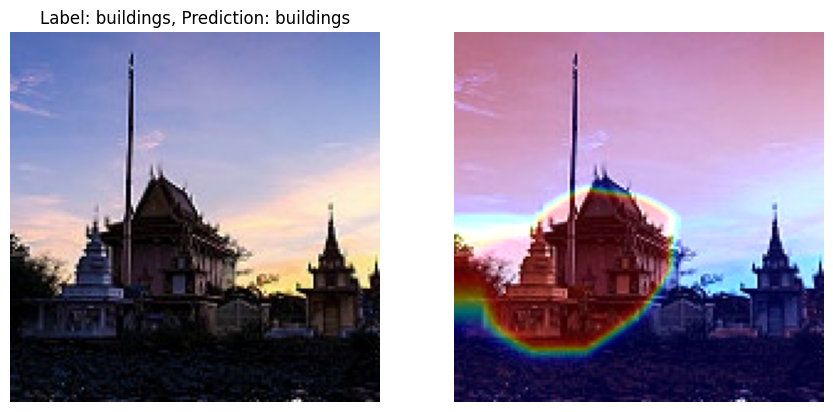

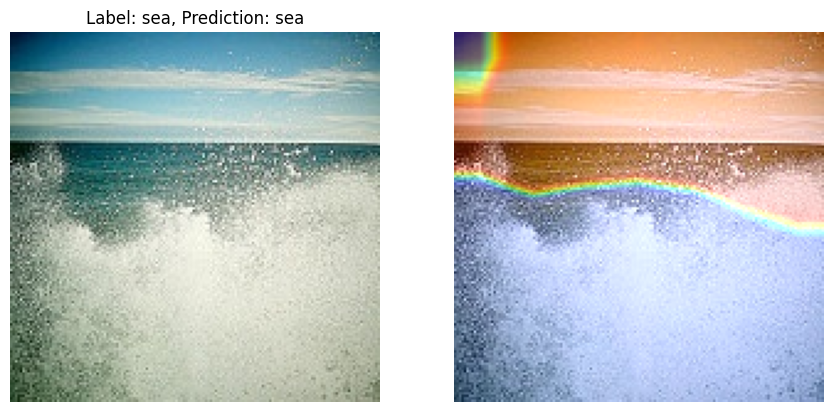

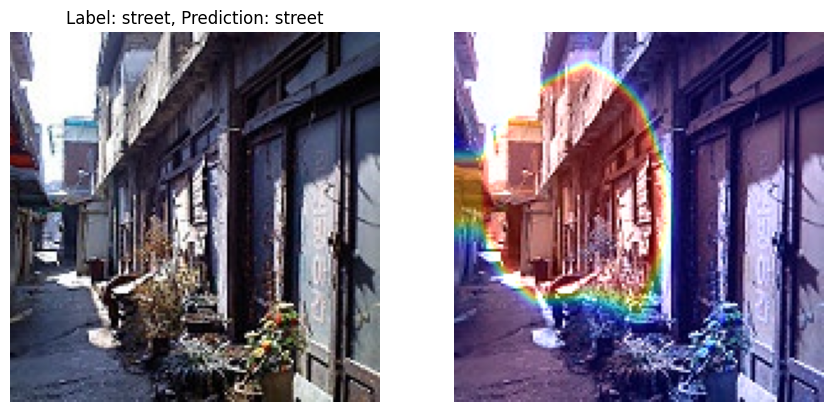

In [22]:
#correct predictions
draw_graphs(net,X_test[317],y_test[317])
draw_graphs(net,X_test[2000],y_test[2000])
draw_graphs(net,X_test[2505],y_test[2505])




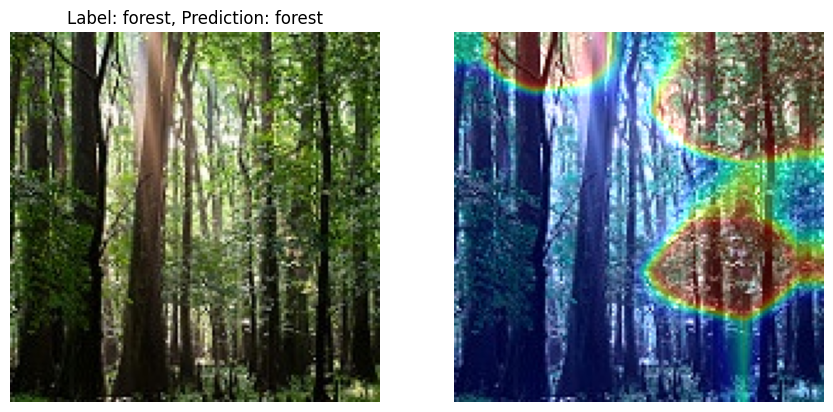

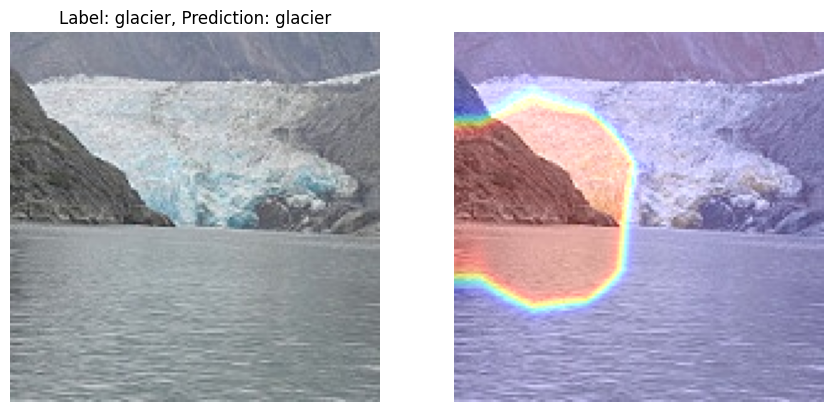

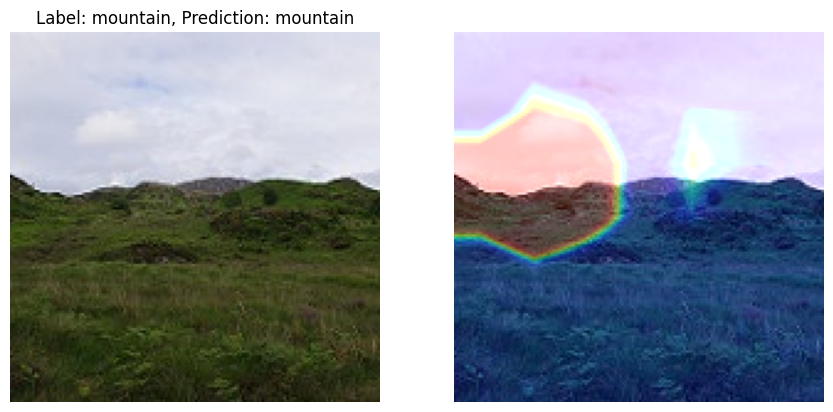

In [94]:
#correct predictions
draw_graphs(net,X_test[477],y_test[477])
draw_graphs(net,X_test[950],y_test[950])
draw_graphs(net,X_test[1479],y_test[1479])


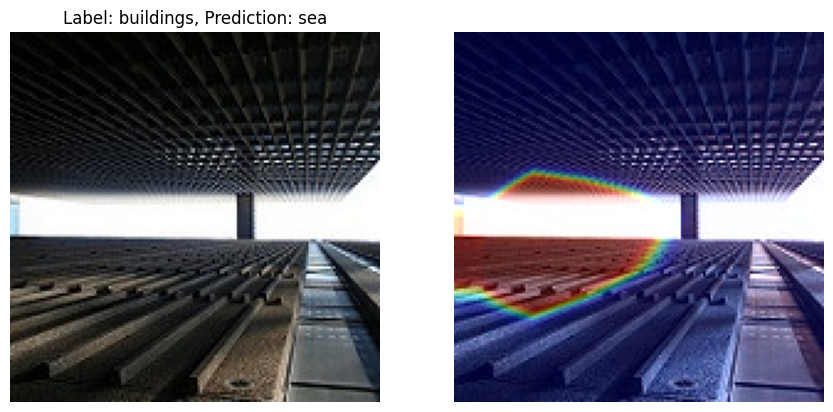

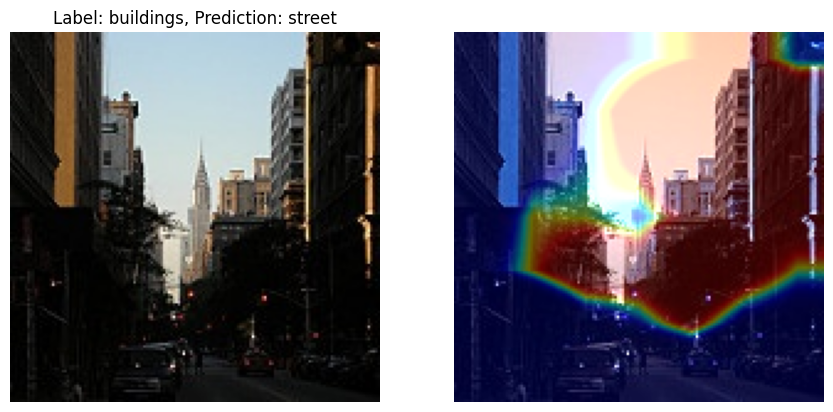

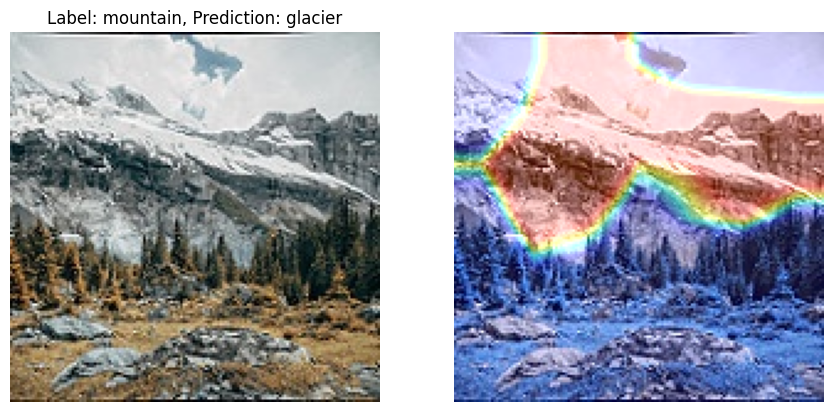

In [95]:
#false predictions
draw_graphs(net,X_test[30],y_test[30])
draw_graphs(net,X_test[86],y_test[86])
draw_graphs(net,X_test[1518],y_test[1518])



In [12]:
#for building focuses on a specific building
#for streets focuses on multiple buildings
#for sea focuses on blue sky
#for mountains focuses on peaks and trees for forest and snow for glacier

Grad-Cam in  Hohman et al. Classification 

Why?

- To understand what model has learn as significant features in images for each class classification.

Who?

- Mostly beneficial for model users and developers

What?

- The output and gradient of last activation layer of convolutional layers with respect to input image. 

How?

- Grad-Cam approach. Weighting the activations of last layer by its pooled gradients, creating a heatmap from these weighted activations and superimposing the heatmap on the input image.

When?

- After training in a trained model.

Where?

- To classify landscapes images into six labels ('buildings' 'forest''glacier' 'mountain' 'sea' 'street')